In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR


from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)

In [2]:
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path, index_col='date')


In [3]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero.1'].isna()
        mask_l = X.loc[:,'LindtSpruengli.1'].isna()

        feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez.1']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero.1']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez.1']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero.1']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli.1']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero.1'].isna()
        mask_l = X.loc[:,'LindtSpruengli.1'].isna()

        #feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        #target_start = y
        #model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez.1']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez.1']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez.1']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero.1']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero.1']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli.1']])


        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [4]:
def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train):
    target_name = 'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.'
    shares = ['Ferrero.1', 'LindtSpruengli.1', 'Mondelez.1']
    columns = [x for x in list(dict_lag) if x not in shares]
    df_selected_col = df.loc[:, shares + columns + [target_name]]
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    # Model
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    mod = Model( columns,
             model_start, model_middle, 
             model_end)
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    results['target']=target_train
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm');
    ax.plot(results.index,results.pred_mf.values, label = 'mf');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl');
    ax.plot(results.index, target_train, color =  'red', label = 'target');
    ax.legend()
    # Predict testdata 
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax_test.plot(results_test.index,results_test.pred_m.values, label = 'm');
    ax_test.plot(results_test.index,results_test.pred_mf.values, label = 'mf');
    ax_test.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl');
    ax_test.plot(results_test.index,target_test, color =  'red', label = 'target');
    ax_test.legend()
    return results, results_test
    

['Beschäftigte_WZ08-1082', 'Umsatz_WZ08-1082', 'EinfPr_Süßwaren (ohne Dauerbackwaren)', 'VPI_Schokoladen', 'PCOCOUSDM', 'PCOFFROBUSDM', 'Geleistete Arbeitsstunden_WZ08-1082', 'Bruttolohn- und -gehaltssumme_WZ08-1082', 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']


(                  pred_m       pred_mf      pred_mfl       target
 index                                                            
 2019-01-31  5.553449e+08           NaN           NaN  461306000.0
 2019-02-28  5.530723e+08           NaN           NaN  503777000.0
 2019-03-31  4.980301e+08           NaN           NaN  476975000.0
 2019-04-30  4.843280e+08           NaN           NaN  525599000.0
 2019-05-31  5.069282e+08           NaN           NaN  635907000.0
 ...                  ...           ...           ...          ...
 2024-10-31  8.047254e+08  8.099457e+08           NaN  941120000.0
 2024-11-30  6.940985e+08  6.816765e+08  6.200521e+08  620313000.0
 2024-12-31  7.407195e+08  7.332413e+08  6.179656e+08  612725000.0
 2025-01-31  7.444740e+08  7.335237e+08  6.708191e+08  680198000.0
 2025-02-28  7.437298e+08  7.307848e+08  7.307693e+08  726370000.0
 
 [74 rows x 4 columns],
                   pred_m       pred_mf      pred_mfl       target
 index                              

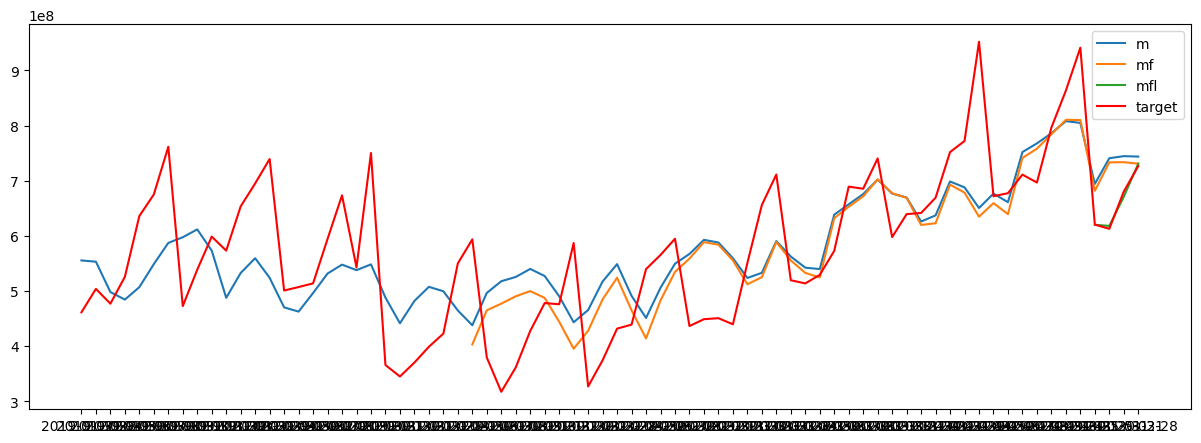

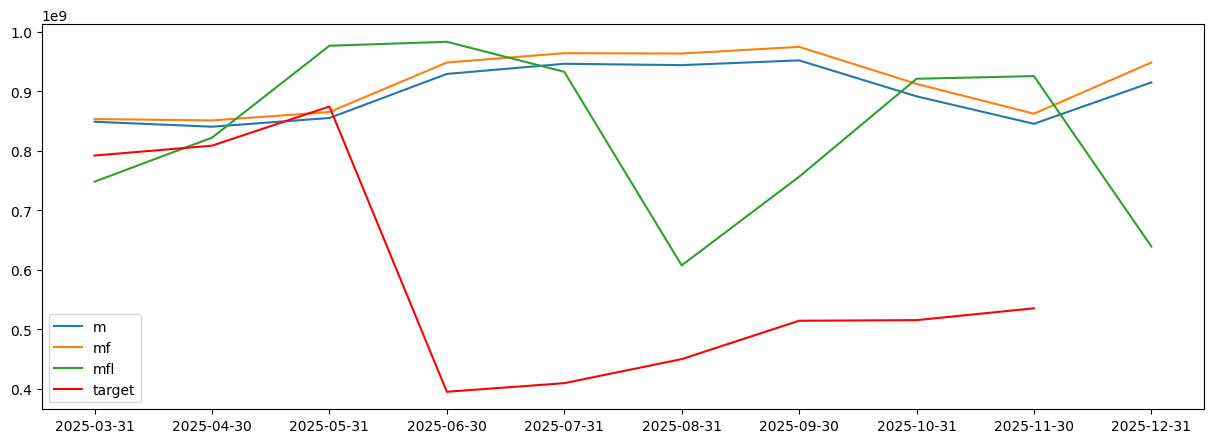

In [5]:
columns = ['Beschäftigte_WZ08-1082',
 'Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'Umsatz_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
number_train = 74
shares = ['Ferrero.1', 'LindtSpruengli.1', 'Mondelez.1']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in ['Beschäftigte_WZ08-1082',
 'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in ['Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082','ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


print([x for x in list(dict_lag) if x not in shares])
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)

c:\Users\judit\Portfolioproject_mit_Salima\dpp_projekt_2026\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,pred_m,pred_mf,pred_mfl,target
index,,,,
2019-01-31,74.0,NaN,NaN,461306000.0
2019-02-28,74.0,NaN,NaN,503777000.0
2019-03-31,74.0,NaN,NaN,476975000.0
2019-04-30,74.0,NaN,NaN,525599000.0
2019-05-31,74.0,NaN,NaN,635907000.0
...,...,...,...,...
2024-10-31,74.0,257419.0,NaN,941120000.0
2024-11-30,74.0,257419.0,6.801980e+08,620313000.0
2024-12-31,74.0,257419.0,6.801980e+08,612725000.0


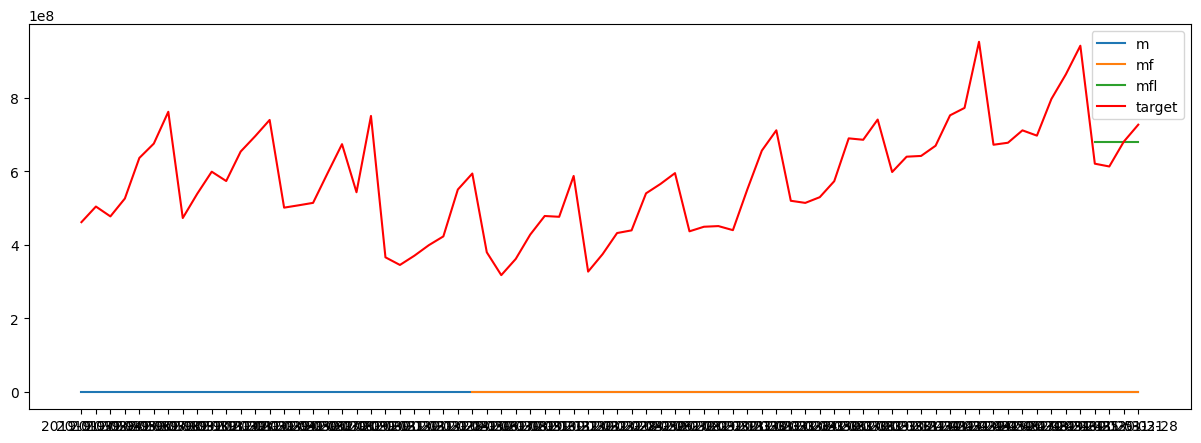

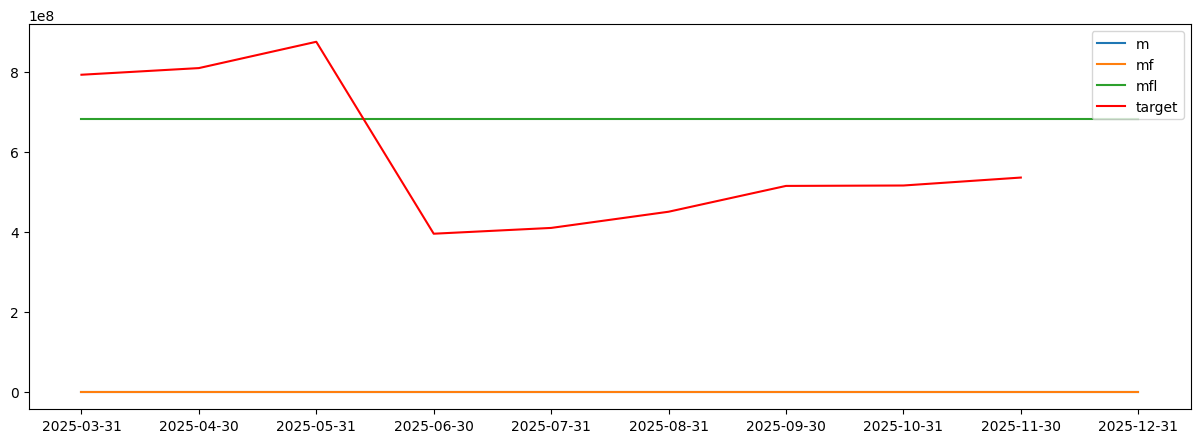

In [6]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)
results

In [ ]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)
results

,pred_m,pred_mf,pred_mfl,target
index,,,,
2019-01-31,461306000.0,NaN,NaN,461306000.0
2019-02-28,476975000.0,NaN,NaN,503777000.0
2019-03-31,476975000.0,NaN,NaN,476975000.0
2019-04-30,673417000.0,NaN,NaN,525599000.0
2019-05-31,635907000.0,NaN,NaN,635907000.0
...,...,...,...,...
2024-10-31,941120000.0,941120000.0,NaN,941120000.0
2024-11-30,740334000.0,620313000.0,612725000.0,620313000.0
2024-12-31,612725000.0,597681000.0,612725000.0,612725000.0


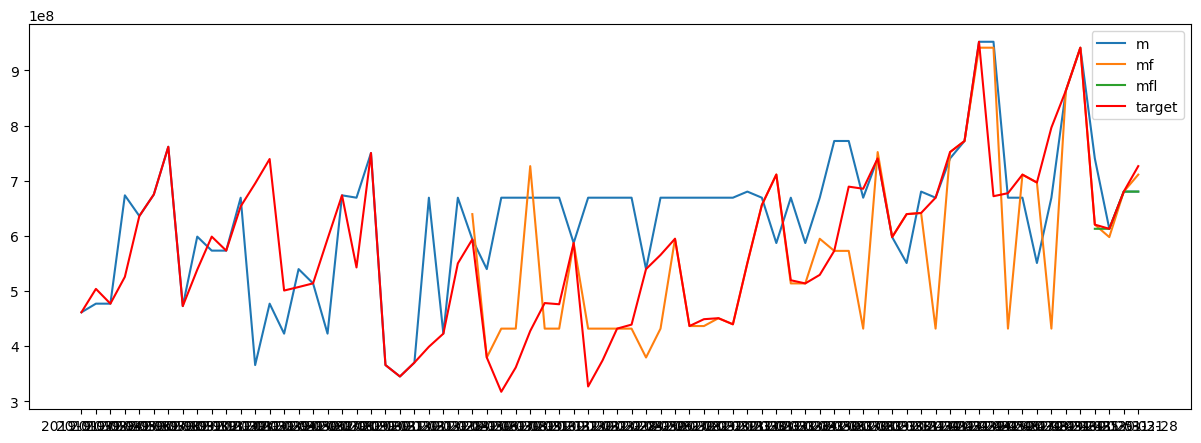

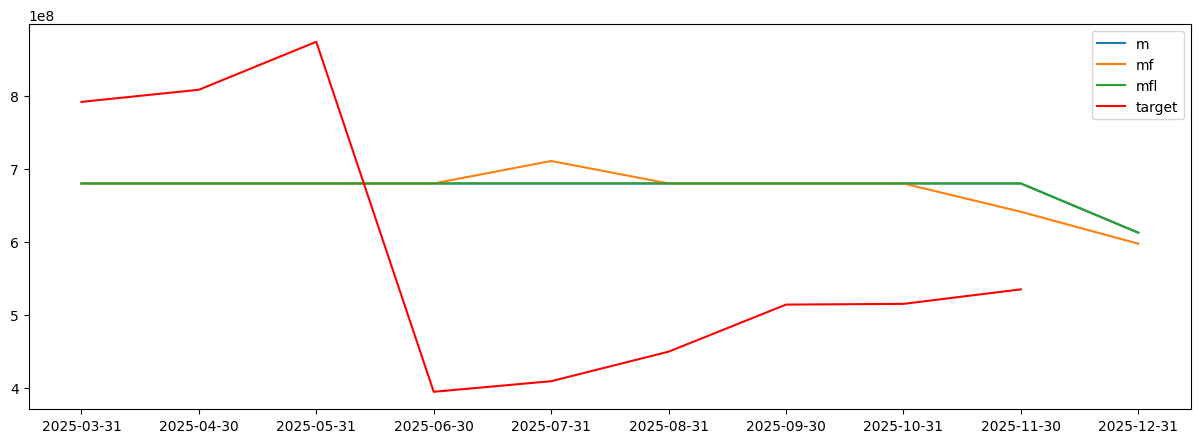

In [8]:
model_start = RandomForestClassifier(n_estimators=5, max_depth=5)
model_middle = RandomForestClassifier(n_estimators=5, max_depth=5)
model_end = RandomForestClassifier(n_estimators=5, max_depth=5)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train)
results